In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import os
import cv2
import time
import json
from PIL import Image
from prettytable import PrettyTable
from sklearn.utils import shuffle
from scipy.signal import medfilt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

In [2]:
class Activation:
    def relu(self, X):
        """
        Memberikan nilai output berupa fungsi ReLU dari X
        
        Parameter:
        X: Numpy 2D Array berukuran (jumlah fitur, jumlah data)
        
        Return:
        Y: Numpy 2D Array yang merupakan output dari fungsi ReLU
        """
        Y = np.maximum(X, 0)
        return Y
    
    def softmax(self, X):
        """
        Memberikan nilai output berupa fungsi Softmax dari X
        
        Parameter:
        X: Numpy 2D Array berukuran (jumlah fitur, jumlah data)
        
        Return:
        Y: Numpy 2D Array yang merupakan output dari fungsi Softmax
        """
        # Menghindari overflow (https://www.techopedia.com/definition/663/overflow-error#:~:text=In%20computing%2C%20an%20overflow%20error,of%20its%20ability%20to%20handle.)
        X -= np.max(X, axis=0, keepdims=True)
        # Perhitungan
        exp_X = np.exp(X)
        sum_exp_X = np.sum(exp_X, axis=0, keepdims=True)
        Y = exp_X / sum_exp_X
        return Y

In [3]:
class Metrics:
    def categorical_crossentropy(self, Y_pred, Y_true):
        """
        Memberikan nilai output metrik categorical crossentropy dengan membandingkan Y_pred dengan Y_true
        
        Parameter:
        Y_pred: Numpy 2D Array berukuran (jumlah fitur, jumlah data) yang merupakan hasil prediksi
        Y_true: Numpy 2D Array berukuran (jumlah fitur, jumlah data) yang merupakan nilai target pada data
        
        Return:
        cost: Nilai skalar yang merupakan hasil output dari categorical crossentropy
        """
        # Perhitungan
        cross_entropy = -np.sum(Y_true * np.log(Y_pred))
        cost = cross_entropy / Y_true.shape[1]
        return cost

    def accuracy(self, Y_pred, Y_true):
        """
        Memberikan nilai output metrik akurasi
        
        Parameter:
        Y_pred: Numpy 2D Array berukuran (jumlah fitur, jumlah data) yang merupakan hasil prediksi
        Y_true: Numpy 2D Array berukuran (jumlah fitur, jumlah data) yang merupakan nilai target pada data
        
        Return:
        acc: Nilai skalar yang merupakan hasil output dari akurasi
        """
        pred_matrix = Y_pred == np.max(Y_pred, axis=0)
        acc = np.sum(pred_matrix * Y_true) / Y_pred.shape[1]
        return acc

In [4]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0
        
    def update(self, w, dw):
        if self.m is None:
            self.m = np.zeros_like(w)
            self.v = np.zeros_like(w)
            
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * dw
        self.v = self.beta2 * self.v + (1 - self.beta2) * (dw**2)
        mb = self.m / (1 - self.beta1**self.t)
        vb = self.v / (1 - self.beta2**self.t)
        w -= self.lr * mb / (np.sqrt(vb) + self.epsilon)
        
        return w

In [5]:
class Conv2D(Activation):
    def __init__(self, filters, kernel_size, activation="relu", input_shape=(None,)):
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.input_shape = (None,) + input_shape
        self.alias = "conv_2d"
        
    def initialize_parameters(self, lr, beta1, beta2, epsilon):
        # Ukuran Output
        self.output_shape = (None, self.input_shape[1] - self.kernel_size[0] + 1, self.input_shape[2] - self.kernel_size[1] + 1,
                             self.filters)
        # Kernel
        self.W = np.random.randn(self.filters, self.kernel_size[0], self.kernel_size[1], self.input_shape[-1]) * 0.001
        self.adam_W = Adam(lr, beta1, beta2, epsilon)
        # Bias
        self.B = np.zeros((self.filters, 1))
        self.adam_B = Adam(lr, beta1, beta2, epsilon)
        # Jumlah Parameter
        self.param_nums = np.prod(self.W.shape) + np.prod(self.B.shape)
    
    def convolution(self, X, W, B=np.array(0)):
        """
        Mengembalikan matriks citra hasil konvolusi
        
        Parameter:
        X: Matriks Input Numpy Array 4D berukuran (jumlah data, panjang pixel, lebar pixel, anchor)
        W: Matriks Kernel Numpy Array 4D berukuran (panjang kernel, lebar kernel, anchor input, jumlah filter)
        B: Vektor Bias (Default: 0)
        
        Return:
        conv_images: Matriks Konvolusi Numpy Array 4D
        """
        conv_images = np.zeros((X.shape[0], X.shape[1] - W.shape[1] + 1, \
                                     X.shape[2] - W.shape[2] + 1, W.shape[0]))
        img_len, conv_x, conv_y, filters = conv_images.shape
        for idx in range(img_len):
            for i in range(conv_x):
                for j in range(conv_y):
                    sub_image = X[idx, i:i+W.shape[1], j:j+W.shape[2], :]
                    conv_images[idx, i, j, :] = np.sum(sub_image * W, axis=(1, 2, 3)) + B.flatten()
        return conv_images
    
    def forward(self, X):
        self.Z = self.convolution(X, self.W, self.B)
        if self.activation.lower() == "relu":
            self.A = super().relu(self.Z)
        return self.A
    
    def backpro(self, prev_layer, next_layer):
        dC = np.zeros_like(self.A)
        img_len, m, n, anchors = self.A.shape
        
        # Jika ukuran output adalah ganjil
        if m % 2 == 1:
            m -= 1
        if n %2 == 1:
            n -= 1
        
        for idx in range(img_len):
            for i in range(0, m, 2):
                for j in range(0, n, 2):
                    sub_C = self.A[idx, i:i+2, j:j+2, :]
                    dC[idx, i:i+2, j:j+2, :] = np.where(sub_C == np.max(sub_C, axis=(0, 1), keepdims=True),
                                                        np.reshape(next_layer.dP[idx, int(i/2), int(j/2), :], (1, 1, -1)), 0) /\
                                               np.where(np.sum(sub_C == np.max(sub_C, axis=(0, 1), keepdims=True), axis=(0, 1), keepdims=True) > 1, 2, 1)
        # dC/dZ
        if self.activation.lower() == "relu":
            dCdZ = np.where(self.Z > 0, 1, 0)
        # dZ = dcost/dZ
        self.dZ = dC * dCdZ
        
        if hasattr(prev_layer, "A"):
            self.dW = self.convolution(prev_layer.A.T, self.dZ.T).T / img_len
        else:
            self.dW = self.convolution(prev_layer.T, self.dZ.T).T / img_len
            
        self.dB = np.expand_dims(np.sum(self.dZ, axis=(0, 1, 2)), axis=-1) / img_len

In [6]:
class MaxPooling(Conv2D):
    def __init__(self, pool_size=(2, 2), input_shape=(None,)):
        self.pool_size = pool_size
        self.input_shape = (None,) + input_shape
        self.alias = "maxpool_2d"
        
    def initialize_parameters(self, lr, beta1, beta2, epsilon):
        # Ukuran Output
        self.output_shape = (None, self.input_shape[1] // self.pool_size[0], \
                             self.input_shape[2] // self.pool_size[1], self.input_shape[-1])
        # Banyak parameter
        self.param_nums = 0
        
    def pooling(self, X, pool_size=(2, 2)):
        """
        Mengembalikan matriks citra hasil max pooling
        
        Parameter:
        X: Matriks Input Numpy Array 4D berukuran (jumlah data, panjang pixel, lebar pixel, anchor)
        pool_size: Ukuran sub-matriks Numpy Array 2D yang akan diterapkan operasi max pooling
        
        Return:
        pooled_images: Matriks Pooling Numpy Array 4D
        """
        img_len, pooled_x, pooled_y, anchors = X.shape[0], X.shape[1] // pool_size[0], X.shape[2] // pool_size[1], X.shape[-1]
        pooled_images = np.zeros((img_len, pooled_x, pooled_y, anchors))
        
        for idx in range(img_len):  
            for i in range(0, pooled_x*pool_size[0], pool_size[0]):
                for j in range(0, pooled_y*pool_size[1], pool_size[1]):
                    sub_image = X[idx, i:i+pool_size[0], j:j+pool_size[1], :]
                    pooled_images[idx, int(i/pool_size[0]), int(j/pool_size[1]), :] = np.max(sub_image, axis=(0, 1))
        return pooled_images
    
    def forward(self, X):
        self.A = self.pooling(X, self.pool_size)
        return self.A
    
    def backpro(self, prev_layer, next_layer):
        if next_layer.alias == "flatten":
            self.dP = np.reshape(next_layer.dZ.T, newshape=self.A.shape)
        else:
            padded_size = next_layer.kernel_size[0] - 1
            padded_dZ = np.pad(next_layer.dZ, ((0, 0), (padded_size, padded_size), (padded_size, padded_size), (0, 0)))
            rotated_W = np.rot90(next_layer.W, axes=(1, 2), k=2)
            self.dP = super().convolution(X=padded_dZ, W=rotated_W.swapaxes(0, -1))

In [7]:
class Flatten:
    def __init__(self, input_shape=(None,)):
        self.input_shape = (None,) + input_shape
        self.alias = "flatten"
        
    def initialize_parameters(self, lr, beta1, beta2, epsilon):
        # Ukuran Output
        self.output_shape = (np.prod(self.input_shape[1:]), None)
        # Jumlah Parameter
        self.param_nums = 0
        
    def flatten(self, X):
        """
        Mengubah matriks citra berdimensi 4 menjadi matriks berdimensi 2
        
        Parameter:
        X: Matriks Input Numpy Array 4D berukuran (jumlah data, panjang pixel, lebar pixel, anchor)
        
        Return:
        flat_images: Matriks Flatten Numpy Array 2D berukuran (jumlah fitur, jumlah data)
        """
        flat_images = np.reshape(X, (X.shape[0], -1))
        return flat_images.T
    
    def forward(self, X):
        self.A = self.flatten(X)
        return self.A
    
    def backpro(self, prev_layer, next_layer):
        self.dZ = next_layer.W.T @ next_layer.dZ

In [8]:
class Dense(Activation):
    def __init__(self, neuron, activation="relu", input_shape=(None,)):
        self.neuron = neuron
        self.activation = activation
        self.input_shape = (None,) + input_shape
        self.alias = "dense"
    
    def initialize_parameters(self, lr, beta1, beta2, epsilon):
        # Ukuran Output
        self.output_shape = (self.neuron,) + (None,)
        # Weight / Bobot
        self.W = np.random.randn(self.neuron, self.input_shape[0]) * 0.001
        self.adam_W = Adam(lr, beta1, beta2, epsilon)
        # Bias
        self.B = np.zeros((self.neuron, 1))
        self.adam_B = Adam(lr, beta1, beta2, epsilon)
        # Jumlah parameter
        self.param_nums = np.prod(self.W.shape) + np.prod(self.B.shape)
    
    def forward(self, inputs):
        self.Z = self.W @ inputs + self.B
        if self.activation == "relu":
            activation_func = super().relu
        elif self.activation == "softmax":
            activation_func = super().softmax
        self.A = activation_func(self.Z)
        return self.A
    
    def backpro(self, prev_layer, next_layer):
        img = self.A.shape[1]
        if self.activation == "relu":
            diff_Z = np.where(self.Z >= 0, 1, 0)
            self.dZ = (next_layer.W.T @ next_layer.dZ) * diff_Z
        elif self.activation == "softmax":
            self.dZ = self.A - next_layer

        self.dW = self.dZ @ prev_layer.A.T / img
        self.dB = np.sum(self.dZ, axis=1, keepdims=True) / img

In [9]:
class Sequential(Metrics):
    def __init__(self, layers, lr, beta1, beta2, epsilon):
        self.layers = layers
        self.history = {"acc": [], "loss": [], "val_acc": [], "val_loss": []}
        self.initialize_parameters(lr, beta1, beta2, epsilon)
    
    def initialize_parameters(self, lr, beta1, beta2, epsilon):
        for idx, layer in enumerate(self.layers):
            if idx != 0:
                layer.input_shape = self.layers[idx-1].output_shape
            layer.initialize_parameters(lr, beta1, beta2, epsilon)
    
    def summary(self):
        """
        Menampilkan tabel yang berisi layer-layer yang dipakai dan banyak parameternya
        """
        total_param_nums = 0
        table = PrettyTable()
        table.field_names = ["Layer", "Output Shape", "Number of Parameters"]
        for layer in self.layers:
            total_param_nums += layer.param_nums
            table.add_row([layer.alias, layer.output_shape, layer.param_nums])
        table.align = "r"
        print(table,"\n")
        print("===========================================================\n")
        print(f"Number of Parameters: {total_param_nums}")
        
    # Algoritma Feed Forward
    def feed_forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs
    
    # Algoritma Backpropagation
    def backpropagation(self, inputs, targets):
        for idx, layer in enumerate(self.layers[::-1]):
            prev_idx, next_idx = len(self.layers)-idx-2, len(self.layers)-idx
            # Lapisan terakhir
            if idx == 0:
                next_layer = targets
            else:
                next_layer = self.layers[next_idx]
            # Lapisan pertama
            if prev_idx == -1:
                prev_layer = inputs
            else:
                prev_layer = self.layers[prev_idx]
            layer.backpro(prev_layer=prev_layer, next_layer=next_layer)
            
    # Adaptive Moment Estimation
    def adam_optimize(self):
        layers_with_parameters = [layer for layer in self.layers if (layer.alias == "dense" or layer.alias == "conv_2d")]
        for layer in layers_with_parameters:
            layer.W = layer.adam_W.update(layer.W, layer.dW)
            layer.B = layer.adam_B.update(layer.B, layer.dB)
    
    # Melakukan pelatihan model
    def fit(self, inputs, targets, epochs=10, train_batch_size=32, validation_data=None):
        for epoch in range(epochs):
            # Epoch i-th
            print(f"Epoch {epoch+1}:")
            batches = math.ceil(len(inputs)/train_batch_size)
            acc = 0
            loss = 0
            for batch in range(batches):
                if batch != range(batches)[-1]:
                    inputs_batch = inputs[batch*train_batch_size:(batch+1)*train_batch_size]
                    targets_batch = targets[:,batch*train_batch_size:(batch+1)*train_batch_size]
                else:
                    inputs_batch = inputs[batch*train_batch_size:]
                    targets_batch = targets[:,batch*train_batch_size:]  
                start = time.time()
                
                # Feed Forward Algorithm
                train_y_pred = self.feed_forward(inputs_batch)
                # Show metrics
                acc += super().accuracy(train_y_pred, targets_batch)
                loss += super().categorical_crossentropy(train_y_pred, targets_batch)
                # Backpropagation Algorithm
                self.backpropagation(inputs_batch, targets_batch)
                # Optimizer: Adam
                self.adam_optimize()
                
                end = time.time()
                duration = round(end - start)
                print(f"Batch {batch+1}/{batches} | duration: {duration // 60}:{duration %  60} | accuracy: {acc/(batch+1)} | loss: {loss/(batch+1)}")
            
            # Validation data
            if validation_data and len(validation_data) == 2:
                test_y_pred = self.feed_forward(validation_data[0])
                val_acc = super().accuracy(test_y_pred, validation_data[1])
                val_loss = super().categorical_crossentropy(test_y_pred, validation_data[1])
                print(f"Result:\naccuracy: {acc/batches} | loss: {loss/batches} | val_accuracy: {val_acc} | val_loss: {val_loss}")
            print("\n")
            
            # Append the metric
            self.history["acc"].append(acc/batches)
            self.history["loss"].append(loss/batches)
            self.history["val_acc"].append(val_acc)
            self.history["val_loss"].append(val_loss)
                
    def save(self):
        i = 1
        layers_with_parameters = [layer for layer in self.layers if (layer.alias == "dense" or layer.alias == "conv_2d")]

        for layer in layers_with_parameters:
            np.save(f"Saved Model/W{i}.npy", layer.W)
            np.save(f"Saved Model/B{i}.npy", layer.B)
            i += 1
            
    def load(self):
        i = 1
        layers_with_parameters = [layer for layer in self.layers if (layer.alias == "dense" or layer.alias == "conv_2d")]

        for layer in layers_with_parameters:
            layer.W = np.load(f"Saved Model/W{i}.npy")
            layer.B = np.load(f"Saved Model/B{i}.npy")
            i += 1
            
    def predict(self, image_file):
        # Load model
        self.load()
        
        # Mengubah dimensi data citra yang akan diprediksi menjadi 4 dimensi
        image = cv2.imread(image_file)
        img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        ## Segmentasi gambar
        # perform median blur
        img_filt = cv2.medianBlur(img_gray, 5)

        # perform Otsu's thresholding
        _, thresh = cv2.threshold(img_filt, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # perform morphological opening to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        # perform morphological closing to fill gaps
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

        # find contours of breast region
        contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        breast_contour = max(contours, key=cv2.contourArea)

        # create mask of breast region
        mask = cv2.drawContours(img_filt.copy(), [breast_contour], 0, 255, -1)

        # apply mask to original image
        img_filt = cv2.resize(img_filt, model.layers[0].input_shape[1:3])
        mask = cv2.resize(mask, model.layers[0].input_shape[1:3]) == 255
        breast = img_filt * mask

        # perform histogram equalization
        img_eq = cv2.equalizeHist(breast)
        
        converted_image = np.expand_dims(img_eq, axis=(0, -1)) / 255
        
        # Feed Forward
        y_pred = self.feed_forward(converted_image)
        
        # Menunjukkan hasil per layer
        ## Data original
        print("Original Image")
        plt.imshow(image, cmap="gray")
        plt.show()
        print("---"*12)
        
        ## Pemrosesan data per layer
        inputs = converted_image.copy()
        for layer in self.layers:
            inputs = layer.forward(inputs)
            if layer.alias in ("conv_2d", "maxpool_2d"):
                print(layer.alias)
                for filt in range(128):
                    if np.sum(inputs[0, :, :, filt]) > 0:
                        plt.imshow(inputs[0, :, :, filt], cmap="gray")
                        plt.title(f"Filter {filt+1}")
                        plt.show()
            print("---"*12)
        
        # Memberi prediksi
        plt.imshow(image, cmap="gray")
        plt.show()
        print(f"Hasil Prediksi Citra: {IDX_TO_PATHOLOGY[np.argmax(y_pred)]}")
        print(f"Target Citra: {image_file.replace('.jpg', '')}")

## Test

In [10]:
PATHOLOGY_TO_IDX = {"BENIGN": 0, "BENIGN_WITHOUT_CALLBACK": 1, "MALIGNANT": 2}
IDX_TO_PATHOLOGY = {idx: pathology for pathology, idx in PATHOLOGY_TO_IDX.items()}

def data_preprocessing(csv_file, image_size=(100, 100)):
    images_matrix = []
    labels_matrix = []
    
    # Memuat data pada file csv
    data = pd.read_csv(csv_file)
    data = data[["pathology", "image file path"]]
    data.drop_duplicates(subset="image file path", inplace=True)
    
    # Mengambil path subdir terakhir
    for column in data.columns:
        if column != "pathology":
            data[column] = data[column].apply(lambda x: x.split("/")[-2])
    
    # Pemrosesan data
    for idx, row in data.iterrows():
        # Citra original
        img_path = f"Data/jpeg/{row['image file path']}"
        img = cv2.imread(f"{img_path}/{os.listdir(img_path)[0]}")
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ## Segmentasi gambar
        # perform median blur
        img_filt = cv2.medianBlur(img_gray, 5)

        # perform Otsu's thresholding
        _, thresh = cv2.threshold(img_filt, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

        # perform morphological opening to remove noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        # perform morphological closing to fill gaps
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

        # find contours of breast region
        contours, hierarchy = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        breast_contour = max(contours, key=cv2.contourArea)

        # create mask of breast region
        mask = cv2.drawContours(img_filt.copy(), [breast_contour], 0, 255, -1)

        # apply mask to original image
        img_filt = cv2.resize(img_filt, image_size)
        mask = cv2.resize(mask, image_size) == 255
        breast = img_filt * mask

        # perform histogram equalization
        img_eq = cv2.equalizeHist(breast)
        
        images_matrix.append(breast)
            
        # Pemrosesan Target
        labels_vector = np.zeros(len(PATHOLOGY_TO_IDX))
        labels_vector[PATHOLOGY_TO_IDX[row['pathology']]] = 1
        
        labels_matrix.append(labels_vector)
            
    images_matrix = np.expand_dims(images_matrix, axis=-1) / 255
    labels_matrix = np.array(labels_matrix)
    
    # Randomize the data
    random_num = random.randint(0, 100)
    X, Y = shuffle(images_matrix, labels_matrix, random_state=random_num)
    return X, Y.T

Ukuran data citra latih: (2458, 50, 50, 1)
Ukuran data target pada citra latih: (3, 2458) 

------------------------------ 

Ambil sembarang citra pada data latih


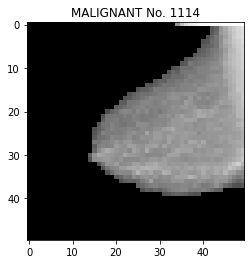

In [11]:
# train_calc_images, train_calc_labels = data_preprocessing("Data/csv/calc_case_description_train_set.csv", image_size=(50, 50))
# train_mass_images, train_mass_labels = data_preprocessing("Data/csv/mass_case_description_train_set.csv", image_size=(50, 50))
# test_calc_images, test_calc_labels = data_preprocessing("Data/csv/calc_case_description_test_set.csv", image_size=(50, 50))
# test_mass_images, test_mass_labels = data_preprocessing("Data/csv/mass_case_description_test_set.csv", image_size=(50, 50))

# train_images, train_labels = np.concatenate((train_calc_images, train_mass_images), axis=0), np.concatenate((train_calc_labels, train_mass_labels), axis=1)
# test_images, test_labels = np.concatenate((test_calc_images, test_mass_images), axis=0), np.concatenate((test_calc_labels, test_mass_labels), axis=1)

# # train_images, train_labels = np.concatenate((train_images, test_images[:-100]), axis=0), np.concatenate((train_labels, test_labels[:, :-100]), axis=1)
# # test_images, test_labels = test_images[-100:], test_labels[:, -100:]

# test_images = np.concatenate((train_images[-350:], test_images[-295:]), axis=0)
# test_labels = np.concatenate((train_labels[:, -350:], test_labels[:, -295:]), axis=1)

# train_images, train_labels = shuffle(train_images, train_labels.T, random_state=42)
# train_labels = train_labels.T

# print(train_images.shape)
# print(test_images.shape)
# print(train_labels.shape)
# print(test_labels.shape)

# np.save("train_images.npy", train_images)
# np.save("test_images.npy", test_images)
# np.save("train_labels.npy", train_labels)
# np.save("test_labels.npy", test_labels)

train_images = np.load("train_images.npy")
train_labels = np.load("train_labels.npy")
# test_images = np.load("test_images.npy")
# test_labels = np.load("test_labels.npy")

print(f"Ukuran data citra latih: {train_images.shape}")
print(f"Ukuran data target pada citra latih: {train_labels.shape}", "\n")
# print(f"Ukuran data citra uji secara utuh: {test_images.shape}")
# print(f"Ukuran data target pada citra uji secara utuh: {test_labels.shape}")
print("---"*10, "\n")

# new_test_images = test_images[-295:-195].copy()
# new_test_labels = test_labels[:, -295:-195].copy()

# print(f"Ukuran data citra uji secara utuh: {new_test_images.shape}")
# print(f"Ukuran data target pada citra uji secara utuh: {new_test_labels.shape}")
# print("---"*10, "\n")

print("Ambil sembarang citra pada data latih")
random_num = random.randint(0, len(train_images) - 1)

plt.imshow(train_images[random_num], cmap="gray")
plt.title(f"{IDX_TO_PATHOLOGY[np.argmax(train_labels[:, random_num])]} No. {random_num}")
plt.show()

### Demo

In [12]:
model = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-7)

model.summary()

+------------+---------------------+----------------------+
|      Layer |        Output Shape | Number of Parameters |
+------------+---------------------+----------------------+
|    conv_2d | (None, 48, 48, 128) |                 1280 |
| maxpool_2d | (None, 24, 24, 128) |                    0 |
|    flatten |       (73728, None) |                    0 |
|      dense |         (512, None) |             37749248 |
|      dense |           (3, None) |                 1539 |
+------------+---------------------+----------------------+ 


Number of Parameters: 37752067


In [13]:
demo_imgs = [file for file in os.listdir() if ".jpg" in file]
demo_imgs

['Benign Without Callback.jpg', 'Benign.jpg', 'Malignant.jpg']

Original Image


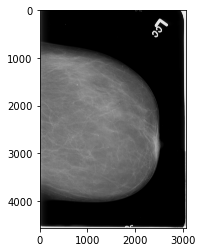

------------------------------------
conv_2d


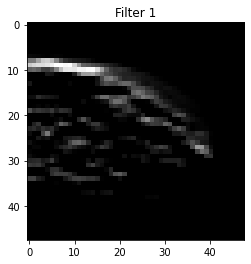

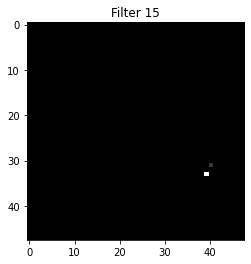

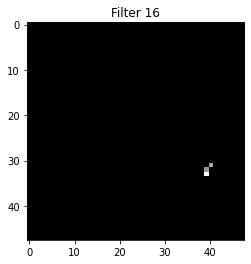

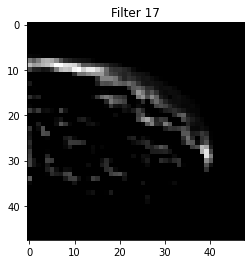

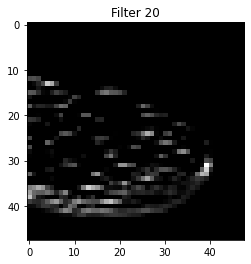

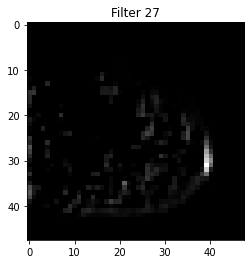

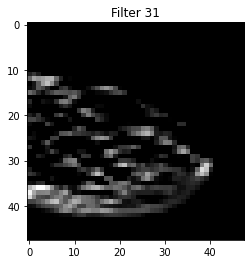

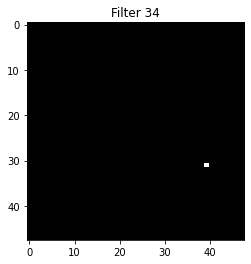

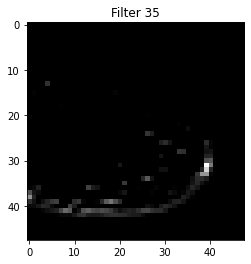

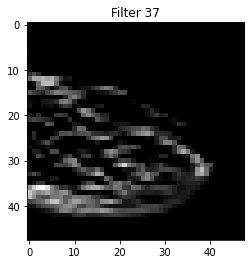

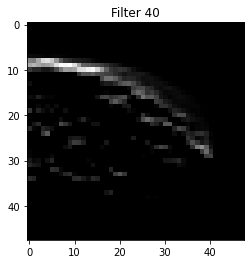

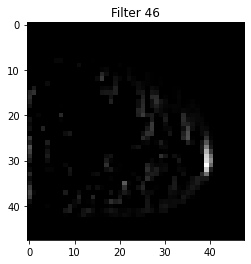

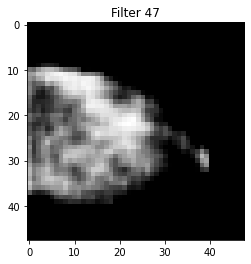

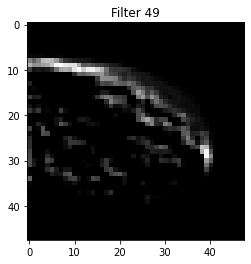

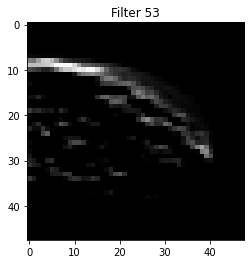

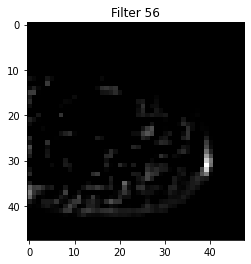

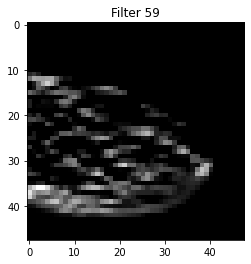

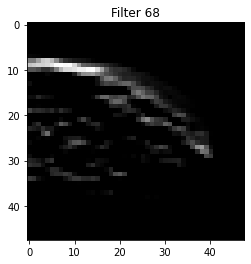

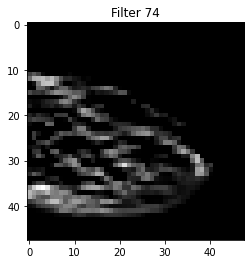

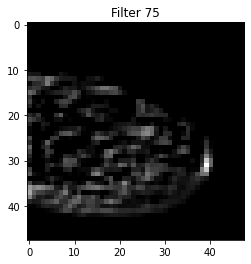

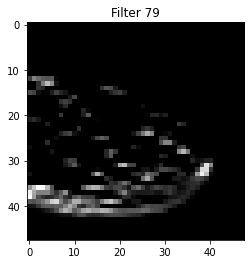

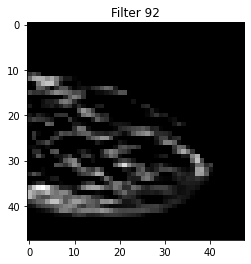

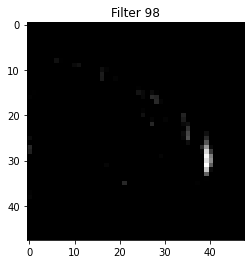

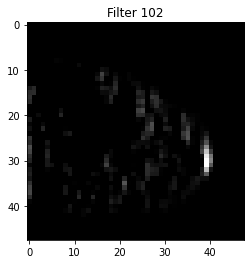

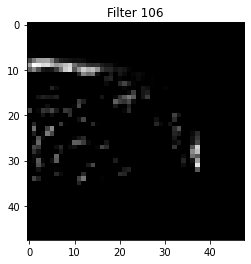

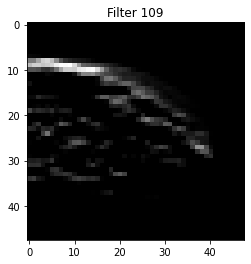

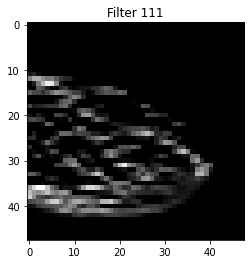

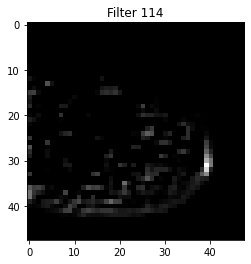

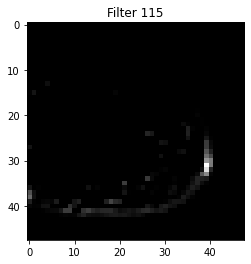

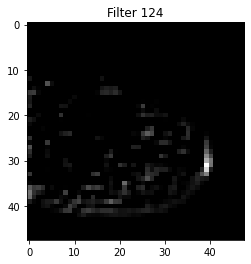

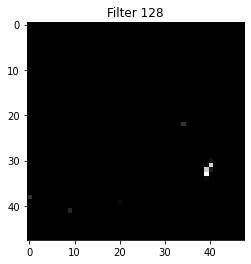

------------------------------------
maxpool_2d


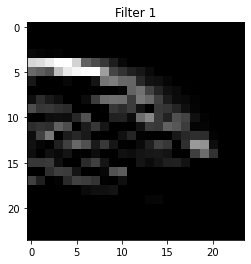

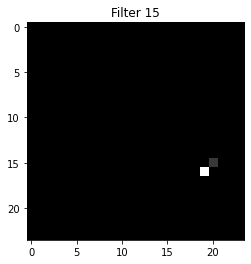

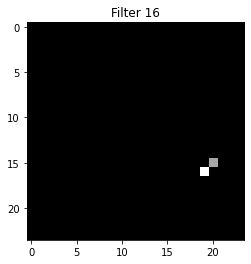

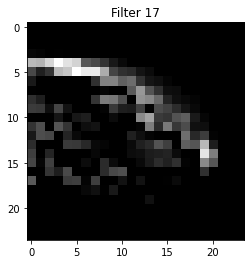

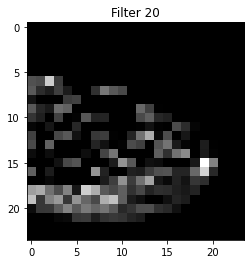

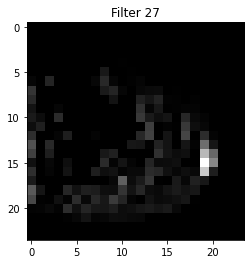

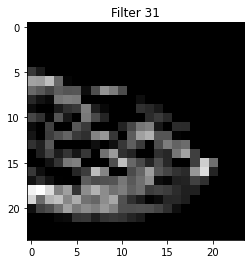

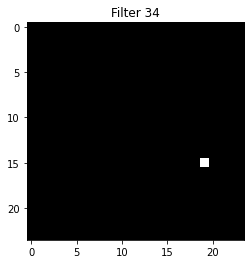

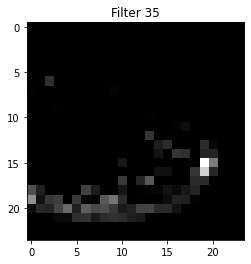

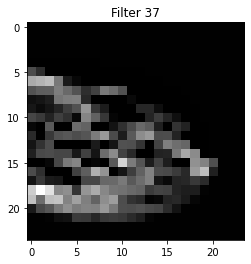

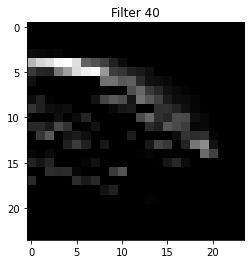

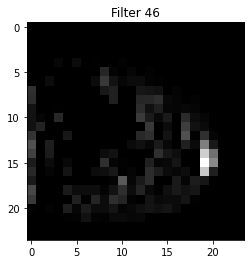

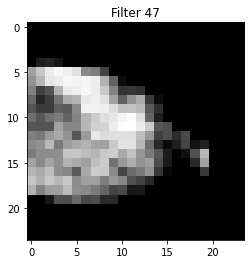

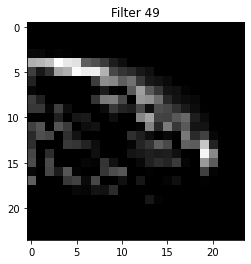

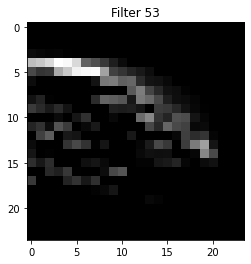

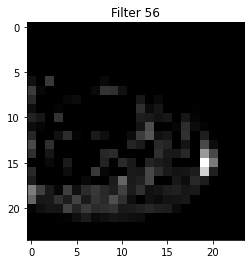

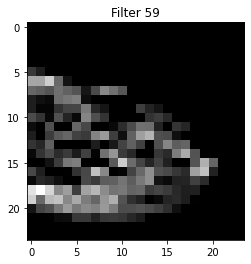

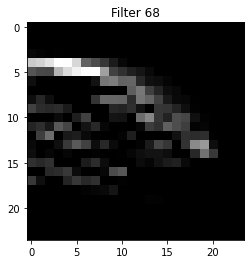

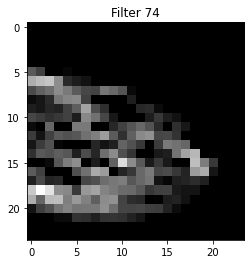

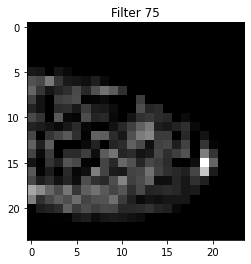

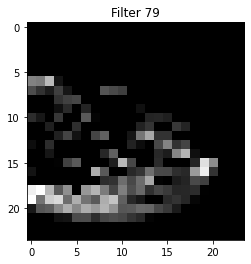

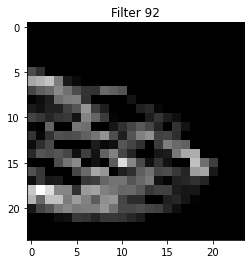

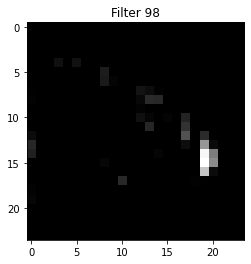

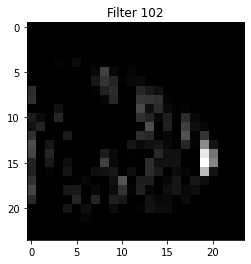

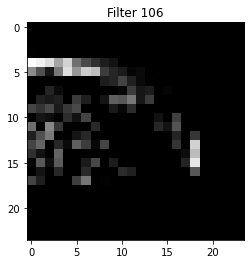

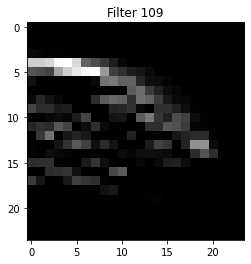

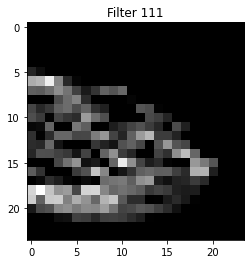

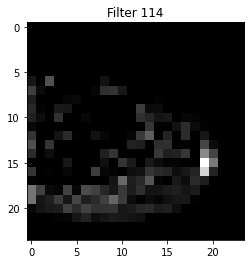

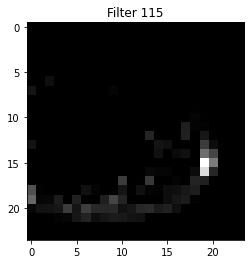

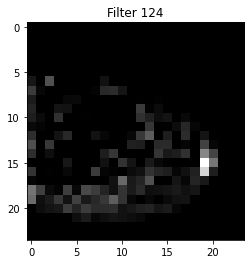

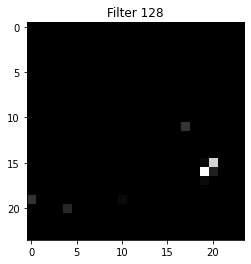

------------------------------------
------------------------------------
------------------------------------
------------------------------------


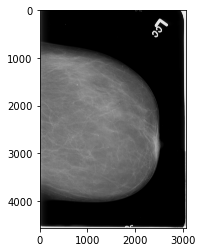

Hasil Prediksi Citra: BENIGN
Target Citra: Benign Without Callback


In [14]:
# Choice: {0, 1, 2}
choice = 0
model.predict(demo_imgs[choice])

### 1e-3 dan 64 (Done)

In [15]:
model_1 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_1.summary()

+------------+---------------------+----------------------+
|      Layer |        Output Shape | Number of Parameters |
+------------+---------------------+----------------------+
|    conv_2d | (None, 48, 48, 128) |                 1280 |
| maxpool_2d | (None, 24, 24, 128) |                    0 |
|    flatten |       (73728, None) |                    0 |
|      dense |         (512, None) |             37749248 |
|      dense |           (3, None) |                 1539 |
+------------+---------------------+----------------------+ 


Number of Parameters: 37752067


In [17]:
model_1.fit(train_images, train_labels, train_batch_size=64, epochs=30)

Epoch 1:
Batch 1/39 | duration: 0:9 | accuracy: 0.4375 | loss: 1.0153909831825407
Batch 2/39 | duration: 0:9 | accuracy: 0.4765625 | loss: 0.9833018364761459
Batch 3/39 | duration: 0:9 | accuracy: 0.4479166666666667 | loss: 0.9787857637304221
Batch 4/39 | duration: 0:10 | accuracy: 0.41796875 | loss: 0.9848261210706848
Batch 5/39 | duration: 0:10 | accuracy: 0.409375 | loss: 0.9964390519456952
Batch 6/39 | duration: 0:9 | accuracy: 0.4166666666666667 | loss: 0.9909361123867444
Batch 7/39 | duration: 0:10 | accuracy: 0.421875 | loss: 0.987393389571588
Batch 8/39 | duration: 0:9 | accuracy: 0.419921875 | loss: 0.981132635099691
Batch 9/39 | duration: 0:10 | accuracy: 0.4288194444444444 | loss: 0.9758324689981799
Batch 10/39 | duration: 0:10 | accuracy: 0.434375 | loss: 0.9713571424805316
Batch 11/39 | duration: 0:10 | accuracy: 0.4318181818181818 | loss: 0.9748351608098151
Batch 12/39 | duration: 0:10 | accuracy: 0.4231770833333333 | loss: 0.9829848362072141
Batch 13/39 | duration: 0:10 

UnboundLocalError: local variable 'val_acc' referenced before assignment

In [ ]:
sns.set_style("whitegrid")

# Accuracy
sns.lineplot(x=range(1, len(model_1.history["acc"]) + 1), 
             y=model_1.history["acc"],
             label="Accuracy"
            )
# Validation Accuracy
sns.lineplot(x=range(1, len(model_1.history["val_acc"]) + 1), 
             y=model_1.history["val_acc"],
             label="Validation Accuracy"
            )

# More information
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
# Accuracy
sns.lineplot(x=range(1, len(model_1.history["loss"]) + 1), 
             y=model_1.history["loss"],
             label="Loss"
            )

# Validation Accuracy
sns.lineplot(x=range(1, len(model_1.history["val_loss"]) + 1), 
             y=model_1.history["val_loss"],
             label="Validation Loss"
            )

# More information
plt.title("Model Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### 1e-3 dan 32

In [ ]:
model_2 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_2.summary()

In [ ]:
model_2.fit(train_images, train_labels, train_batch_size=32, epochs=30, validation_data=(new_test_images, new_test_labels))

### 1e-3 dan 128

In [ ]:
model_3 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_3.summary()

In [ ]:
model_3.fit(train_images, train_labels, train_batch_size=128, epochs=30, validation_data=(new_test_images, new_test_labels))

### 1e-2 dan 64

In [ ]:
model_4 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-2, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_4.summary()

In [ ]:
model_4.fit(train_images, train_labels, train_batch_size=64, epochs=30, validation_data=(new_test_images, new_test_labels))

### 1e-2 dan 32

In [ ]:
model_5 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-2, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_5.summary()

In [ ]:
model_5.fit(train_images, train_labels, train_batch_size=32, epochs=30, validation_data=(new_test_images, new_test_labels))

### 1e-2 dan 128

In [ ]:
model_6 = Sequential([
    Conv2D(128, (3,3), activation="relu", input_shape=(50, 50, 1)),
    MaxPooling((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(3, activation="softmax")
], 
    lr=1e-2, beta1=0.9, beta2=0.999, epsilon=1e-7)

model_6.summary()

In [ ]:
model_6.fit(train_images, train_labels, train_batch_size=128, epochs=30, validation_data=(new_test_images, new_test_labels))